# Descrição de Atividade

Nessa atividade você irá usar seus conhecimentos sobre classificação para prever quais candidatos à Câmara de Deputados foram eleitos nas eleições de 2014. De forma específica:

 1. Há desbalanceamento das classes (isto é, uma classe tem muito mais instâncias que outra)? Em que proporção? Quais efeitos colaterais o desbalanceamento de classes pode causar no classificador? Como você poderia tratar isso? (1 pt.)
 2. Treine: um modelo de regressão logística, KNN, uma árvore de decisão e um modelo de adaboost. Tune esses modelos usando validação cruzada e controle overfitting se necessário, considerando as particularidades de cada modelo.  (2 pts.)
Reporte Precision, Recall e AUC-Precision&Recall no treino e validação. Há uma grande diferença de desempenho no treino/validação? Como você avalia os resultados? Justifique sua resposta. (2 pt.)
 3. Interprete as saídas dos modelos. Quais atributos parecem ser mais importantes de acordo com cada modelo?  (2 pts.)
 4. Envie seus melhores modelos à competição do Kaggle. Faça pelo menos uma submissão. Sugestões para melhorar o modelo: (2 pts.)
 5. Experimente outros modelos (e.g. SVM, RandomForests e GradientBoosting).
 6. Experimente outras estratégias de ensembles (e.g. Stacking).
 7. Experimente balancear as classes,  caso estejam desbalanceadas.

Os dados estão neste link: https://www.kaggle.com/c/ufcg-cdp-20182-lab3/data. Links para um site externo

Para a entrega envie o link no GitHub com o notebook usado para resolver o Lab.


### Descrição dos dados:

Os dados utilizados correspondem aos das eleições de Deputado Federal nos anos de 2006, 2010 e 2014. Estão dividos nas seguintes colunas:

* **ano**: Ano da eleição;
* **sequencial_candidato**: O identificador do candidato. Corresponde à coluna Id do arquivo de submissão;
* **nome**: Nome do candidato;
* **uf**: Sigla do estado do candidato;
* **partido**: Partido do candidato;
* **quantidade_doacoes**: Número de doações que um candidato recebeu;
* **quantidade_doadores**: Numero de doadores que um candidato teve;
* **total_receita**: Total de receita de um candidato;
* **media_receita**: Média da receita de um candidato;
* **recursos_de_outros_candidatos.comites**: Total de receita proveniente de outros candidatos e comitês;
* **recursos_de_pessoas_fisicas**: Total de receita proveniente de pessoas físicas;
* **recursos_de_pessoas_juridicas**: Total de receita proveniente de pessoas juridicas;
* **recursos_proprios**:Total de receita proveniente dos próprios candidatos;
* **recursos_de_partido_politico**: Total de receita proveniente do partido do candidato;
* **quantidade_despesas**: Número de despesas que um candidato teve;
* **quantidade_fornecedores**: Número de fornecedores que um candidato teve;
* **total_despesa**: Total de depesa de um candidato;
* **media_despesa**: Média da despesa de um candidato;
* **cargo**: Cargo ao qual o candidato está concorrendo;
* **sexo**: Sexo do candidato;
* **grau**: Grau de escolaridade do candidato;
* **estado_civil**: Estado civil do candidato;
* **ocupacao**: Ocupação do candidato;
* **situacao**: Situação final do candidato. Corresponde à coluna **Predict** do arquivo de submissão;

## Import Libraries

In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate, cross_val_predict
from sklearn.externals.joblib import Parallel, delayed
from sklearn.utils.fixes import signature

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import xgboost as xgb
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE, ADASYN

from collections import Counter

from enum import Enum

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

py.init_notebook_mode(connected=True)

sns.set(style="ticks")

## Load Data

In [2]:
train_df = pd.read_csv('../data/assignment_4/train.csv')
test_df = pd.read_csv('../data/assignment_4/test.csv')

data = pd.concat([train_df, test_df], sort=False)

data.set_index('sequencial_candidato', inplace=True, drop=True)

## Preprocess Data

In [3]:
data.drop(columns=['nome'], inplace=True)

In [4]:
qt = QuantileTransformer(random_state=2, output_distribution='normal')

skewed_features = ['quantidade_doacoes', 'quantidade_doadores', 'total_receita',
       'media_receita', 'recursos_de_outros_candidatos.comites',
       'recursos_de_pessoas_fisicas', 'recursos_de_pessoas_juridicas',
       'recursos_proprios', 'recursos_de_partido_politico',
       'quantidade_despesas', 'quantidade_fornecedores', 'total_despesa',
       'media_despesa']

data[skewed_features] = qt.fit_transform(X=data[skewed_features])

In [5]:
cleanup_nums = {"grau" : {"LÊ E ESCREVE": 1, 
                       "ENSINO FUNDAMENTAL INCOMPLETO":2, 
                       "ENSINO FUNDAMENTAL COMPLETO":3, 
                       "ENSINO MÉDIO INCOMPLETO":4,
                       "ENSINO MÉDIO COMPLETO":5,
                       "SUPERIOR INCOMPLETO":6,
                       "SUPERIOR COMPLETO": 7}}

data.replace(cleanup_nums, inplace=True)
data["grau"] = pd.to_numeric(data["grau"])

In [6]:
categorical_feats = [col for col in data.columns if not np.issubdtype(data[str(col)].dtype, np.number) and col not in ['nome', 'situacao']]

data = pd.get_dummies(data, columns=categorical_feats)
data.shape

(12214, 258)

## Split Data into Train and Test

In [7]:
data['situacao_dummy'] = data['situacao'].map({'eleito': 1, 'nao_eleito': 0})

train = data[(data.ano == 2006) | (data.ano == 2010)]
test = data[data.ano == 2014]

print(train.shape)
print(test.shape)

(7622, 259)
(4592, 259)


## Target Class Imbalancing

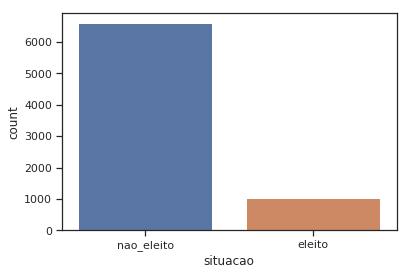

In [8]:
sns.countplot(x='situacao', data=train)

In [9]:
num_elected_candidates = train.situacao[train.situacao == 'eleito'].count()
num_not_elected_candidates = train.situacao[train.situacao == 'nao_eleito'].count()
total_candidates = train.shape[0]

print("Número de candidatos Eleitos: {}".format(num_elected_candidates))
print("Número de candidatos Não-Eleitos: {}".format(num_not_elected_candidates))
print("Total de candidatos: {}\n".format(total_candidates))

print("Proporção de candidatos eleitos: {:2.2%}".format((num_elected_candidates/total_candidates)))
print("Proporção de candidatos não-eleitos: {:2.2%}".format((num_not_elected_candidates/total_candidates)))

Número de candidatos Eleitos: 1026
Número de candidatos Não-Eleitos: 6596
Total de candidatos: 7622

Proporção de candidatos eleitos: 13.46%
Proporção de candidatos não-eleitos: 86.54%


A variável alvo **situacao** é bastante _desbalanceada_, em uma proporção de aproximadamente 1 eleito para cada 6 não-eleitos. Precisamente 13.46% dos candidatos foram eleitos, enquanto 86.54% não foram eleitos.

#### Tratando Desbalanceamento

Esse desbalanceamento pode causar alguns efeitos colaterais na classificação feita pelo modelo preditor, tais como overfitting do modelo em relação à classe majoritária, o que prejudica a acurácia da predição, podendo causar até mesmo a interpretação incorreta dos resultados se o desbalanceamento não for endereçado corretamente.

Existem algumas práticas que podemos adotar para corrigir e lidar com esse desbalanceamento, a saber:

* Coleta de mais dados, que poderia rebalancear as classes, a depender da natureza do problema;
* Mudar a forma de amostragem do dataset, a qual pode estar gerando uma amostra desbalanceada, contudo o dataset não está desbalanceado;
* Usar alguma forma de gerar dados sintéticos como Synthetic Minority Over-sampling Technique [SMOTE](https://imbalanced-learn.org/en/stable/over_sampling.html#cbhk2002) e Adaptive Synthetic [ADASYN](https://imbalanced-learn.org/en/stable/over_sampling.html#hbgl2008);
* Incorporar algum modelo que tem uma forma de penalização para compensar o desbalanceamento de classes a exemplo de penalized-LDA e penalized-SVM.


Para essa atividade nós usaremos a técnica de geração de dados sintéticos SMOTE.

In [10]:
train.drop(['situacao'], axis=1, inplace=True)
test.drop(['situacao', 'situacao_dummy'], axis=1, inplace=True)

X = train.loc[:, train.columns != 'situacao_dummy']
y = train.situacao_dummy

X_train, y_train = SMOTE().fit_resample(X, y)
print("Train SMOTE: {}".format(sorted(Counter(y_train).items())))

#X_train = pd.DataFrame(X_train, columns=X.columns)

X_test = test
print("Test.shape: {}".format(X_test.shape))

/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Train SMOTE: [(0.0, 6596), (1.0, 6596)]
Test.shape: (4592, 257)


## Modelos

#### Enumerations

In [11]:
class ModelsPaths(Enum):
    KNR_PATH = 'assignment4-models/knr.p'
    LR_PATH = 'assignment4-models/lr.p'
    DT_PATH = 'assignment4-models/dt.p'
    ADA_PATH = 'assignment4-models/ada.p'
    RF_PATH = 'assignment4-models/rf.p'
    ET_PATH = 'assignment4-models/et.p'
    SVC_PATH = 'assignment4-models/svc.p'
    LGBM_PATH = 'assignment4-models/lgbm.p'
    CAT_PATH = 'assignment4-models/cat.p'
    XGB_PATH = 'assignment4-models/xgb.p'

class ModelsNames(Enum):
    LR = 'Logistic Regression'
    DT = 'Decision Trees'
    ET = 'Extra Trees'
    RF = 'Random Forest'
    ADA = 'AdaBoost'
    SVC = 'Support Vector Machine'
    LGBM = 'LGBM'
    CAT = 'CatBoost'
    XGB = 'XGBoost'
    KNR = 'KNR'

#### Model Parameters

In [12]:
lr_params = {
    'solver': 'liblinear'
}

knr_params = {
    'n_neighbors': 3
}

dt_params = {
    
}

ada_params = {
    'learning_rate': 0.5
}

et_params = {

}

rf_params = {
    
}

svc_params = {
    'probability': True,
    'gamma' : 'auto'
}

lightgbm_params = {
    #'n_estimators':200,
    'learning_rate':0.1,
    #'num_leaves':123,
    #'colsample_bytree':0.8,
    #'subsample':0.9,
    #'max_depth':15,
    #'reg_alpha':0.1,
    #'reg_lambda':0.1,
    #'min_split_gain':0.01,
    #'min_child_weight':2  ,
    'silent': 1,
    'random_state': 42
}

catboost_params = {
    'iterations': 200,
    'learning_rate': 0.5,
    'depth': 3,
    #'l2_leaf_reg': 40,
    #'bootstrap_type': 'Bernoulli',
    #'subsample': 0.7,
    #'scale_pos_weight': 5,
    'eval_metric': 'AUC',
    #'od_type': 'Iter',
    'allow_writing_files': False,
    'verbose': 0
}

xgb_params = {
    #'colsample_bytree': 0.7,
    'silent': 1,
    #'subsample': 0.7,
    'learning_rate': 0.1,
    'objective': 'binary:logistic',
    #'max_depth': 2,
    #'num_parallel_tree': 1,
    #'min_child_weight': 1,
    'nrounds': 250
}

#### Grid Search CV

In [13]:
import warnings; warnings.simplefilter('ignore')

NFOLDS = 3
SEED = 42

# Construct some pipelines
pipe_rf = Pipeline([('clf', RandomForestClassifier())])
pipe_dt = Pipeline([('clf', DecisionTreeClassifier())])
pipe_ad = Pipeline([('clf', AdaBoostClassifier())])
pipe_kn = Pipeline([('clf', KNeighborsClassifier())])
pipe_et = Pipeline([('clf', ExtraTreesClassifier())])
#pipe_xg = Pipeline([('clf', XGBClassifier())])

grid_params_rf = [{'clf__max_depth' : [2,10,20,100],
                   'clf__random_state' : [SEED]}] 

grid_params_dt = [{'clf__max_depth' : [2,10,20,100],
                  'clf__random_state' : [SEED]}]

grid_params_ad = [{'clf__learning_rate' : [0.5],
                   'clf__random_state': [SEED],
                   'clf__n_estimators': [10, 20, 50]}]

grid_params_kn = [{'clf__n_neighbors': [3]}]

grid_params_et = [{'clf__max_depth' : [2,10,20,100],
                  'clf__random_state' : [SEED]}]


# Construct grid searches
jobs = -1
sc = 'f1'

gs_rf = GridSearchCV(estimator = pipe_rf,
                param_grid = grid_params_rf,
                scoring = sc,
                cv = NFOLDS) 

gs_dt = GridSearchCV(estimator = pipe_dt,
                param_grid = grid_params_dt,
                scoring = sc,
                cv = NFOLDS)

gs_ad = GridSearchCV(estimator = pipe_ad,
                param_grid = grid_params_ad,
                scoring = sc,
                cv = NFOLDS)

gs_kn = GridSearchCV(estimator = pipe_kn,
                param_grid = grid_params_kn,
                scoring = sc,
                cv = NFOLDS)

gs_et = GridSearchCV(estimator = pipe_et,
                param_grid = grid_params_et,
                scoring = sc,
                cv = NFOLDS)

# List of pipelines for ease of iteration
grids = [gs_rf, gs_dt, gs_ad, gs_kn, gs_et]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'Random Forest Classifier', 1: 'Decision Trees', 2: 'AdaBoost Classifier', 
            3: 'KNN Classifier', 4: 'Extra Trees Classifier', 5: 'XGBoost Classifier'}


xx_train, xx_test, yy_train, yy_test = train_test_split(X_train, y_train)

# Fit the grid search objects
print('Performing model optimizations...')
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    
    # Fit grid search
    gs.fit(xx_train, yy_train)

    # Best params
    print('Best params: %s' % gs.best_params_)
    
    # Best training data accuracy
    print('Best F1 score for training set: %.4f' % gs.best_score_)
    
    # Validation data accuracy of model with best params
    print('Test set F1 score for best params: %.4f ' % f1_score(y_true=yy_test, y_pred=gs.predict(xx_test)))
    
    print("----------------")

Performing model optimizations...

Estimator: Random Forest Classifier
Best params: {'clf__max_depth': 20, 'clf__random_state': 42}
Best F1 score for training set: 0.9438
Test set F1 score for best params: 0.9536 
----------------

Estimator: Decision Trees
Best params: {'clf__max_depth': 10, 'clf__random_state': 42}
Best F1 score for training set: 0.9324
Test set F1 score for best params: 0.9358 
----------------

Estimator: AdaBoost Classifier
Best params: {'clf__learning_rate': 0.5, 'clf__n_estimators': 50, 'clf__random_state': 42}
Best F1 score for training set: 0.9365
Test set F1 score for best params: 0.9420 
----------------

Estimator: KNN Classifier
Best params: {'clf__n_neighbors': 3}
Best F1 score for training set: 0.9279
Test set F1 score for best params: 0.9397 
----------------

Estimator: Extra Trees Classifier
Best params: {'clf__max_depth': 100, 'clf__random_state': 42}
Best F1 score for training set: 0.9564
Test set F1 score for best params: 0.9673 
----------------


#### Model Definitions

Abaixo definimos alguns wrappers para os modelos que vamos utilizar. Créditos para [**eliotbarr**](https://www.kaggle.com/eliotbarr/stacking-test-sklearn-xgboost-catboost-lightgbm/code) e [**arthurtok**](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python) no Kaggle.

In [14]:
ntrain = X_train.shape[0]
ntest = X_test.shape[0]

NFOLDS = 3
SEED = 42

class GenericWrapper(object):
    def __init__(self, clf, params=None, model_name=None, model_path=None):
        self.clf = clf(**params)
        self.model_name = model_name
        self.model_path = model_path

    def train(self, X_train, y_train):
        self.clf.fit(X_train, y_train)
        self._save_trained_model()

    def predict(self, x):
        return self.clf.predict(x)
    
    def predict_proba(self, x):
        return self.clf.predict_proba(x)[:,1]
    
    def get_clf(self):
        return self._load_trained_model()
    
    def _save_trained_model(self):
        pickle.dump(self.clf, open(self.model_path, 'wb'))

    def _load_trained_model(self):
        return pickle.load(open(self.model_path, 'rb'))

class SklearnWrapper_1(GenericWrapper):
    def __init__(self, clf, seed=0, params=None, model_name=None, model_path=None):
        params['random_state'] = seed
        super().__init__(clf, params, model_name, model_path)
    
    def train(self, X_train, y_train):
        super().train(X_train, y_train)
    
    def predict(self, x):
        return super().predict(x)
    
    def predict_proba(self, x):
        return super().predict_proba(x)
    
    def get_clf(self):
        return super().get_clf()
    
class SklearnWrapper_2(GenericWrapper):
    def __init__(self, clf, params=None, model_name=None, model_path=None):
        super().__init__(clf, params, model_name, model_path)
    
    def train(self, X_train, y_train):
        super().train(X_train, y_train)
    
    def predict(self, x):
        return super().predict(x)
    
    def predict_proba(self, x):
        return super().predict_proba(x)
        
    def get_clf(self):
        return super().get_clf()
    
    
class CatboostWrapper(GenericWrapper):
    def __init__(self, clf, seed=0, params=None, model_name=None, model_path=None):
        params['random_seed'] = seed
        super().__init__(clf, params, model_name, model_path)

    def train(self, X_train, y_train):
        super().train(X_train, y_train)
    
    def predict(self, x):
        return super().predict(x)
    
    def predict_proba(self, x):
        return super().predict_proba(x)
    
    def get_clf(self):
        return super().get_clf()
        

class LightGBMWrapper(GenericWrapper):
    def __init__(self, clf, seed=0, params=None, model_name=None, model_path=None):
        params['feature_fraction_seed'] = seed
        params['bagging_seed'] = seed
        super().__init__(clf, params, model_name, model_path)

    def train(self, X_train, y_train):
        super().train(X_train, y_train)
    
    def predict(self, x):
        return super().predict(x)
    
    def predict_proba(self, x):
        return super().predict_proba(x) 
    
    def get_clf(self):
        return super().get_clf()

    
class XgbWrapper(object):
    def __init__(self, seed=0, params=None, model_name=None, model_path=None):
        self.param = params
        self.param['seed'] = seed
        self.nrounds = params.pop('nrounds', 250)
        self.train_test_cols = [c for c in data.columns if c not in ['situacao', 'situacao_dummy']]
        self.model_name = model_name
        self.model_path = model_path

    def train(self, x_train, y_train):
        dtrain = xgb.DMatrix(pd.DataFrame(x_train, columns=self.train_test_cols), label=y_train)
        self.gbdt = xgb.train(self.param, dtrain, self.nrounds)
        
        self._save_trained_model()

    def predict(self, x):
        preds = self.gbdt.predict(xgb.DMatrix(pd.DataFrame(x, columns=self.train_test_cols)))   
        return [1 if x >= 0.5 else 0 for x in preds]

    def predict_proba(self, x):
        return self.gbdt.predict(xgb.DMatrix(pd.DataFrame(x, columns=self.train_test_cols)))
    
    def _save_trained_model(self):
        pickle.dump(self.gbdt, open(self.model_path, 'wb'))

    def _load_trained_model(self):
        return pickle.load(open(self.model_path, 'rb'))

#### GetOOF Function

In [15]:
def get_oof(clf):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_proba = np.zeros((ntest,))
    
    oof_test_skf = np.empty((NFOLDS, ntest))
    oof_test_skf_proba = np.empty((NFOLDS, ntest))
    
    kf = StratifiedKFold(shuffle=True, random_state=SEED, n_splits=NFOLDS)
    for i, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
        x_tr = X_train[train_index]
        y_tr = y_train[train_index]
        x_te = X_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(X_test)
        oof_test_skf_proba[i, :] = clf.predict_proba(X_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    oof_test_proba[:] = oof_test_skf_proba.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1), oof_test_proba.reshape(-1,1)

#### Training First Level Models

In [17]:
lr = SklearnWrapper_1(clf=LogisticRegression, params=lr_params, model_name=ModelsNames.LR.value, model_path=ModelsPaths.LR_PATH.value)
ad = SklearnWrapper_1(clf=AdaBoostClassifier, seed=SEED, params=ada_params, model_name=ModelsNames.ADA.value, model_path=ModelsPaths.ADA_PATH.value)
et = SklearnWrapper_1(clf=ExtraTreesClassifier, seed=SEED, params=et_params, model_name=ModelsNames.ET.value, model_path=ModelsPaths.ET_PATH.value)
rf = SklearnWrapper_1(clf=RandomForestClassifier, seed=SEED, params=rf_params, model_name=ModelsNames.RF.value, model_path=ModelsPaths.RF_PATH.value)
dt = SklearnWrapper_1(clf=DecisionTreeClassifier, seed=SEED, params=dt_params, model_name=ModelsNames.DT.value, model_path=ModelsPaths.DT_PATH.value)
sv = SklearnWrapper_1(clf=SVC, seed=SEED, params=svc_params, model_name=ModelsNames.SVC.value, model_path=ModelsPaths.SVC_PATH.value)
kn = SklearnWrapper_2(clf=KNeighborsClassifier, params=knr_params, model_name=ModelsNames.KNR.value, model_path=ModelsPaths.KNR_PATH.value)
lg = LightGBMWrapper(clf = LGBMClassifier, seed = SEED, params = lightgbm_params, model_name=ModelsNames.LGBM.value, model_path=ModelsPaths.LGBM_PATH.value)
cb = CatboostWrapper(clf= CatBoostClassifier, seed = SEED, params=catboost_params, model_name=ModelsNames.CAT.value, model_path=ModelsPaths.CAT_PATH.value)
xg = XgbWrapper(seed = SEED, params=xgb_params, model_name=ModelsNames.XGB.value, model_path=ModelsPaths.XGB_PATH.value)

tasks = [lr, ad, et, rf, dt, sv, kn, lg, cb, xg]
#tasks = [ad, et, rf, dt, kn, xg]
results = Parallel(n_jobs=-1, verbose=1)(delayed(get_oof)(md) for md in tasks)

lr_oof_train, lr_oof_test, lr_oof_test_proba = results[0]
ad_oof_train, ad_oof_test, ad_oof_test_proba = results[1]
et_oof_train, et_oof_test, et_oof_test_proba = results[2]
rf_oof_train, rf_oof_test, rf_oof_test_proba = results[3]
dt_oof_train, dt_oof_test, dt_oof_test_proba = results[4]
sv_oof_train, sv_oof_test, sv_oof_test_proba = results[5]
kn_oof_train, kn_oof_test, kn_oof_test_proba = results[6]
lg_oof_train, lg_oof_test, lg_oof_test_proba = results[7]
cb_oof_train, cb_oof_test, cb_oof_test_proba = results[8]
xg_oof_train, xg_oof_test, xg_oof_test_proba = results[9]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    9.1s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.4min finished


### First Level Models Performance Evaluation

In [18]:
def evaluate_inter_models_results(results):
    for m_name, m_train_result in results:        
        print("Model: {}".format(m_name.value))
        print("Precision: {:.4}".format(precision_score(y_train, m_train_result)))
        print("Recall: {:.4}".format(recall_score(y_train, m_train_result)))
        print("F1: {:.4}".format(f1_score(y_train, m_train_result)))
        print("Accuracy: {:.4}".format(accuracy_score(y_train, m_train_result)))
        print("Roc_auc: {:.4}".format(roc_auc_score(y_train, m_train_result)))
        print("----------------------")

res = [(ModelsNames.LR, lr_oof_train), (ModelsNames.ADA, ad_oof_train), 
   (ModelsNames.ET, et_oof_train), (ModelsNames.RF, rf_oof_train), 
   (ModelsNames.DT, dt_oof_train), (ModelsNames.KNR, kn_oof_train), 
   (ModelsNames.SVC, sv_oof_train), (ModelsNames.LGBM, lg_oof_train), 
   (ModelsNames.CAT, cb_oof_train), (ModelsNames.XGB, xg_oof_train)]

#res = [(ModelsNames.ADA, ad_oof_train), 
#   (ModelsNames.ET, et_oof_train), (ModelsNames.RF, rf_oof_train), 
#   (ModelsNames.DT, dt_oof_train), (ModelsNames.KNR, kn_oof_train)]


evaluate_inter_models_results(res)

Model: Logistic Regression
Precision: 0.9015
Recall: 0.9583
F1: 0.929
Accuracy: 0.9268
Roc_auc: 0.9268
----------------------
Model: AdaBoost
Precision: 0.9085
Recall: 0.9663
F1: 0.9365
Accuracy: 0.9345
Roc_auc: 0.9345
----------------------
Model: Extra Trees
Precision: 0.9409
Recall: 0.9854
F1: 0.9627
Accuracy: 0.9618
Roc_auc: 0.9618
----------------------
Model: Random Forest
Precision: 0.9319
Recall: 0.9669
F1: 0.9491
Accuracy: 0.9482
Roc_auc: 0.9482
----------------------
Model: Decision Trees
Precision: 0.9246
Recall: 0.9384
F1: 0.9315
Accuracy: 0.9309
Roc_auc: 0.9309
----------------------
Model: KNR
Precision: 0.8775
Recall: 0.9959
F1: 0.933
Accuracy: 0.9284
Roc_auc: 0.9284
----------------------
Model: Support Vector Machine
Precision: 0.8952
Recall: 0.9698
F1: 0.931
Accuracy: 0.9281
Roc_auc: 0.9281
----------------------
Model: LGBM
Precision: 0.9436
Recall: 0.971
F1: 0.9571
Accuracy: 0.9565
Roc_auc: 0.9565
----------------------
Model: CatBoost
Precision: 0.9412
Recall: 0.96

### Feature Importances Plots

Abaixo listamos as 10 features mais importantes elencadas por diferentes modelos que usamos, após o treinamento destes. Créditos para [**arthurtok**](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python/notebook) no Kaggle.

##### Plotting Functions

In [19]:
def _get_top_10_features_and_imps(f_names, f_imps):
    aux = [(f_name, f_imp) for f_idx_a, f_name in f_names for f_idx_b, f_imp in f_imps if f_idx_a == f_idx_b]
    aux.sort(key=lambda tup: -tup[1]) # sort by feature_importance, descending order

    top_10_features = aux[:10]
    features_names = [x for x,_ in top_10_features]
    features_imps = [y for _,y in top_10_features]

    return (features_names, features_imps)

def _get_feat_names_and_imps_1(model):
    f_names = [(f_idx, f_name) for f_idx, f_name in enumerate(train.columns)]
    f_imps = [(f_idx, f_imp) for f_idx, f_imp in enumerate(model.feature_importances_)]

    return _get_top_10_features_and_imps(f_names, f_imps)

def _get_feat_names_and_imps_2(model):
    imps = (np.std(X_train, 0) * model.coef_)[0]

    f_names = [(f_idx, f_name) for f_idx, f_name in enumerate(train.columns)]
    f_imps = [(f_idx, f_imp) for f_idx, f_imp in enumerate(imps)]

    return _get_top_10_features_and_imps(f_names, f_imps)


def _plot_graph(model_name, features_names, features_imps):
    # Scatter plot 
    trace = go.Scatter(
        y = features_imps,
        x = features_names,
        mode='markers',
        marker=dict(
            sizemode = 'diameter',
            sizeref = 1,
            size = 25,
            color = features_imps,
            colorscale='Portland',
            showscale=True
        ),
        text = features_names
    )
    data = [trace]

    layout= go.Layout(
        autosize= True,
        title= '{} Feature Importance'.format(model_name.value),
        hovermode= 'closest',
        yaxis=dict(
            title= 'Feature Importance',
            ticklen= 5,
            gridwidth= 2
        ),
        showlegend= False
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, filename='scatter2010')


def plot_feature_importances(model, model_name):
    feature_names, feature_imps = None,None

    if model_name in [ModelsNames.DT, ModelsNames.ET, ModelsNames.RF, ModelsNames.ADA]:
        feature_names, feature_imps = _get_feat_names_and_imps_1(model)
    elif model_name in [ModelsNames.LR]:
        feature_names, feature_imps = _get_feat_names_and_imps_2(model)

    _plot_graph(model_name, feature_names, feature_imps)

#### Decision Trees, AdaBoost, Random Forest Classifier e Extra Trees Classifier

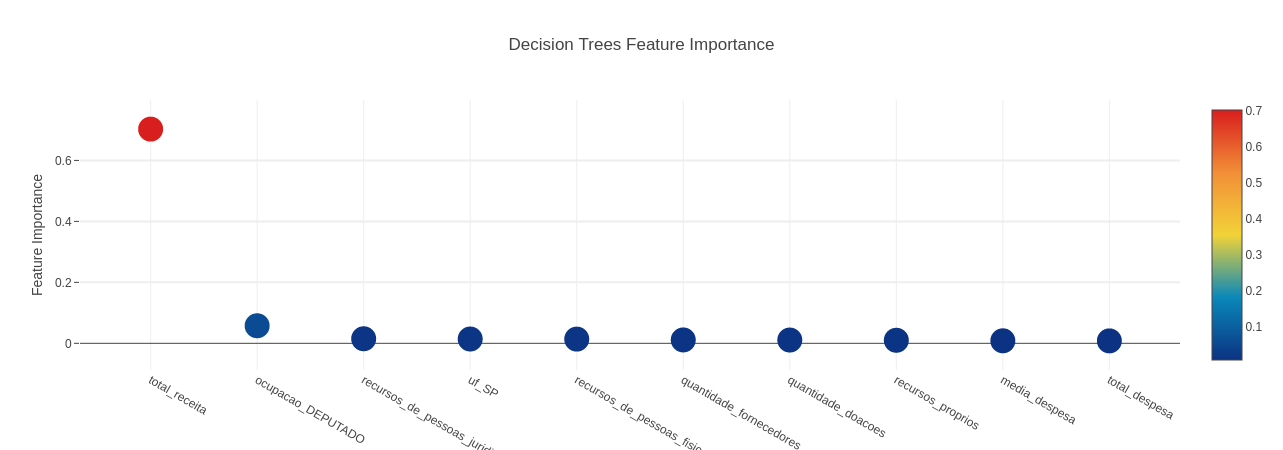

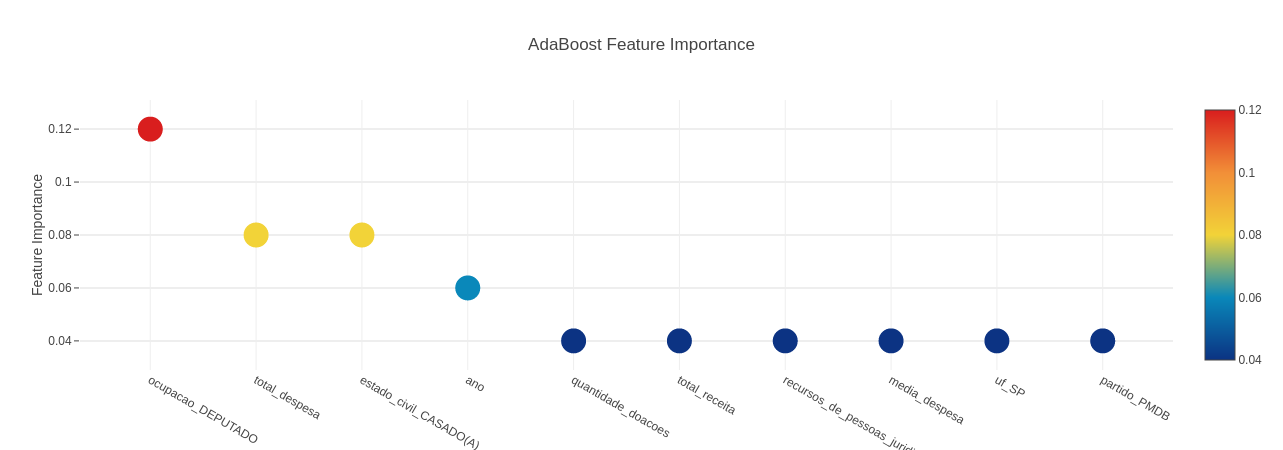

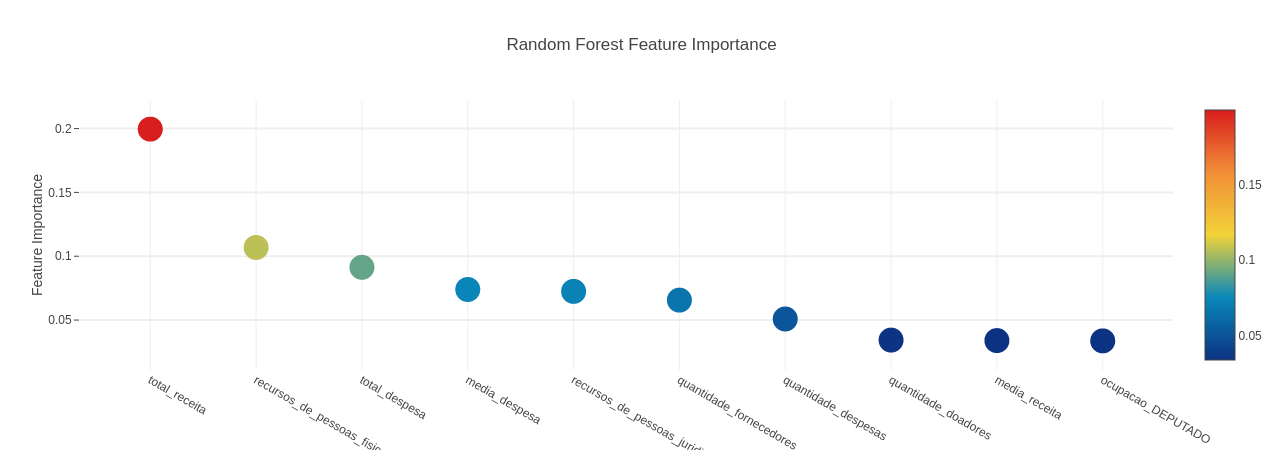

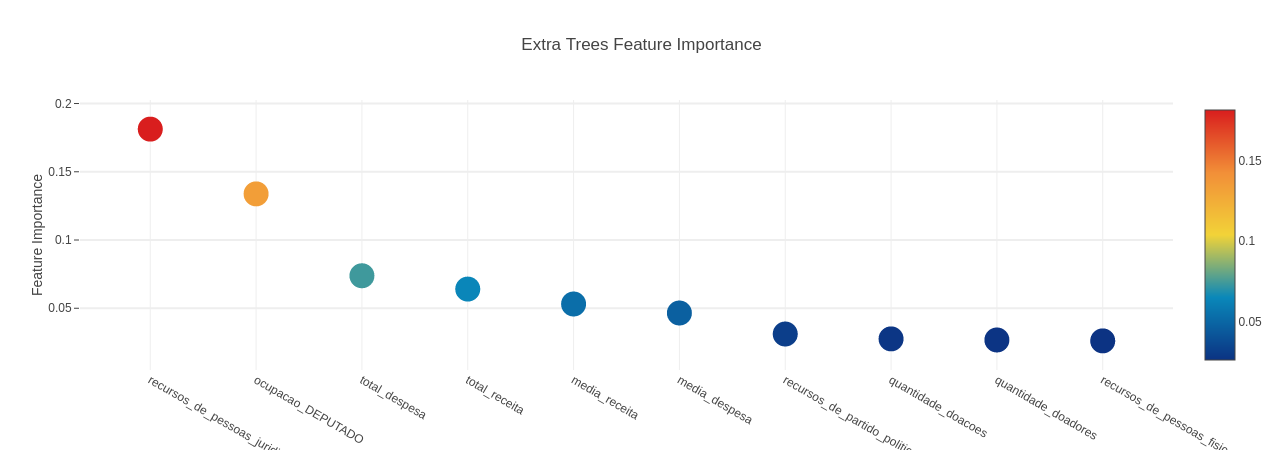

In [99]:
dt_clf = dt.get_clf() 
ad_clf = ad.get_clf() 
rf_clf = rf.get_clf() 
et_clf = et.get_clf() 

models = [(dt_clf, ModelsNames.DT), (ad_clf, ModelsNames.ADA), (rf_clf, ModelsNames.RF), (et_clf, ModelsNames.ET)]

for model, model_name in models:
    plot_feature_importances(model, model_name)

Podemos observar que esses modelos divergem quanto à principal feature que deve ser considerada para que um candidato seja eleito. Entretanto, podemos ver algumas que se repetem e que eles consideram como tendo maior importância:

* total receita
* ocupação Deputado (candidatos tentando reeleição)
* total despesa
* recursos obtidos (pessoas jurídicas, pessoas físicas, etc.)



#### Logistic Regression

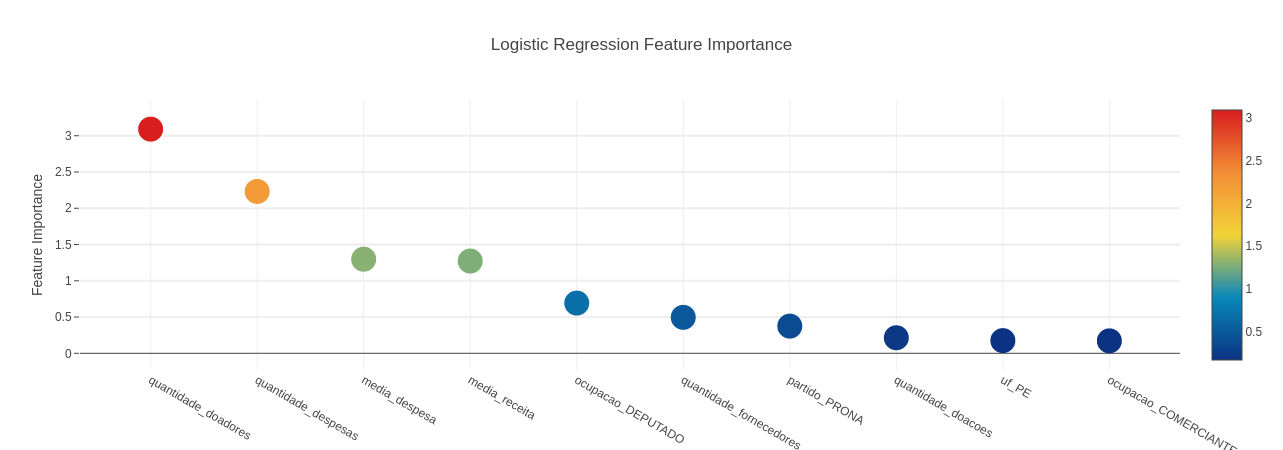

In [21]:
lr_clf = lr.get_clf()
plot_feature_importances(lr_clf, ModelsNames.LR)

O modelo de regressão logística atribui maior importância para a **quantidade de despesas** e a **quantidade de doadores** que um candidato possui como principais fatores para que ele se eleja.

#### KNR

In [100]:
from sklearn.feature_selection import RFE

kn_clf = kn.get_clf() 
rfe = RFE(kn_clf, 10)
fit = rfe.fit(X_train, y_train)

print("Num Features: %d") % fit.n_features_
print("Selected Features: %s") % fit.support_
print("Feature Ranking: %s") % fit.ranking_

RuntimeError: The classifier does not expose "coef_" or "feature_importances_" attributes

# Second Level Training - Stacking

#### Stacked Model Evaluation

In [96]:
def evaluate_stacked_model(model, x__train, y__train):
    xx_train, xx_val, yy_train, yy_val = train_test_split(x__train, y__train, random_state=SEED)
    
    model.fit(xx_train, yy_train)   
    
    #plt.tight_layout()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5), tight_layout=True)
    
    train_preds = model.predict(xx_train)
    print("\nAvaliação de Stacked Model - Train:")
    print("Precision: {:.4}".format(precision_score(yy_train, train_preds)))
    print("Recall: {:.4}".format(recall_score(yy_train, train_preds)))
    print("F1: {:.4}".format(f1_score(yy_train, train_preds)))
    __plot_pr_curve(model, xx_train, yy_train, 'Training', ax1)
    
    val_preds = model.predict(xx_val)      
    print("\nAvaliação de Stacked Model - Validation:")
    print("Precision: {:.4}".format(precision_score(yy_val, val_preds)))
    print("Recall: {:.4}".format(recall_score(yy_val, val_preds)))
    print("F1: {:.4}".format(f1_score(yy_val, val_preds)))
    __plot_pr_curve(model, xx_val, yy_val, 'Validation', ax2)

    
def __plot_pr_curve(model, x_t, y_t, name, ax):
    y_score = model.decision_function(x_t)
    average_precision = average_precision_score(y_t, y_score)
    
    precision, recall, _ = precision_recall_curve(y_t, y_score)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    ax.step(recall, precision, color='b', alpha=0.2, where='post')
    ax.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title('{0} - 2-class PR-curve: AP={1:0.2f}'.format(name, average_precision))

#### Select First Level Models

In [111]:
cols = ['ada', 'et', 'knn', 'lg']

x__train = np.concatenate((ad_oof_train, et_oof_train, kn_oof_train, lg_oof_train), axis=1)
x__test = np.concatenate((ad_oof_test, et_oof_test, kn_oof_test, lg_oof_test), axis=1)
y__train = y_train.copy()

print("x__train.shape: {}".format(x__train.shape))
print("y__train.shape: {}".format(y__train.shape))
print("x__test.shape:{}".format(x__test.shape))

#sns.pairplot(pd.DataFrame(x__train, columns=cols))

x__train.shape: (13192, 4)
y__train.shape: (13192,)
x__test.shape:(4592, 4)


#### Logistic Regression-based Stacking Classifier


Avaliação de Stacked Model - Train:
Precision: 0.9419
Recall: 0.9844
F1: 0.9627

Avaliação de Stacked Model - Validation:
Precision: 0.949
Recall: 0.9879
F1: 0.9681


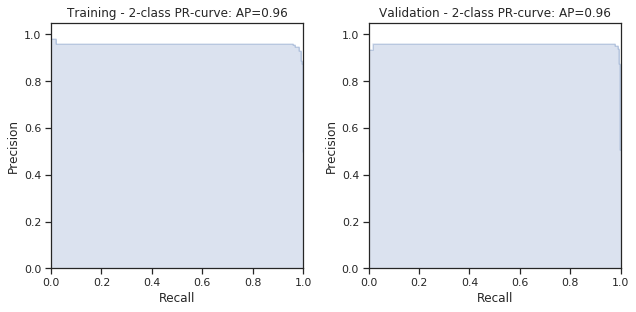

In [112]:
clf = LogisticRegression(solver='liblinear')
clf.fit(x__train, y__train)

evaluate_stacked_model(clf, pd.DataFrame(x__train), pd.DataFrame(y__train))

Podemos observar que não existe muita diferença entre as métricas de validação e de treino, o que é um indício de que não há overfitting do modelo sobre os dados de treino. A precisão média (Average Precision - AP) de ambos os conjuntos de dados, treino e validação, são idênticos.

### Feature Selection of Second Level Model

In [119]:
from sklearn.feature_selection import RFE

rfe = RFE(clf, 4)
fit = rfe.fit(pd.DataFrame(x__train, columns=cols), pd.DataFrame(y__train))

print("Num Features: %d") % fit.n_features_
print("Selected Features: %s") % fit.support_
print("Feature Ranking: %s") % fit.ranking_

Num Features: %d


TypeError: unsupported operand type(s) for %: 'NoneType' and 'int'

### Evaluation

Antes de inserção de xgboost em versão com wrappers:
* Avaliação de Stacked Model com CV:
* Precision: 0.9486
* Recall: 0.9616
* F1: 0.9545
* Accuracy: 0.9548
* Roc_auc: 0.98

Após inserção de xgboost em versão com wrappers:
* Avaliação de Stacked Model com CV:
* Precision: 0.9487
* Recall: 0.9616
* F1: 0.9546
* Accuracy: 0.9549
* Roc_auc: 0.9798

Após tirar alguns modelos da versão final Stacked:
* Avaliação de Stacked Model com CV:
* Precision: 0.9426
* Recall: 0.9753
* F1: 0.9585
* Accuracy: 0.958
* Roc_auc: 0.9788


#### Generate Prediction to Test Data

In [98]:
stack_df = pd.DataFrame(X_test.copy())
pred = clf.predict(x__test)
stack_df['Predicted'] = pred

seq_candidato = stack_df.index

stack_df.replace({'Predicted': {0: 'nao_eleito', 1: 'eleito'}}, inplace=True)
stack_df.reset_index(drop=True, inplace=True)

final_df = pd.DataFrame(columns=['Id','Predicted'])
final_df['Id'] = seq_candidato
final_df['Predicted'] = stack_df['Predicted']

final_df.to_csv('../data/assignment_4/fourth_submission.csv', index=False)
final_df.head(10)

,Id,Predicted
0,10000000135,nao_eleito
1,10000000142,nao_eleito
2,10000000158,nao_eleito
3,10000000161,nao_eleito
4,10000000163,eleito
5,10000000164,nao_eleito
6,10000000166,eleito
7,10000000169,nao_eleito
8,10000000170,nao_eleito
9,10000000171,eleito


Previouslly:

* Precision: 0.9481
* Recall: 0.9884
* F1: 0.9679
* Accuracy: 0.9678
* Roc_auc: 0.9682

After add XGBoostClassifier:

* Precision: 0.9658
* Recall: 0.9807
* F1: 0.9732
* Accuracy: 0.9735
* Roc_auc: 0.9736

### Conclusão

....